In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class ExactGPModel(gpytorch.GPModel):
    def __init__(self):
        super(ExactGPModel,self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

model = ExactGPModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

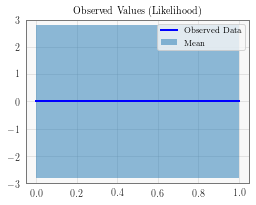

In [6]:
model.eval()
fig = plot_model_and_predictions(model, plot_train_data=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

Iter 1/20 - Loss: 1.223   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/20 - Loss: 1.236   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/20 - Loss: 1.314   log_lengthscale: -0.192   log_noise: -0.200
Iter 4/20 - Loss: 1.212   log_lengthscale: -0.288   log_noise: -0.299
Iter 5/20 - Loss: 1.094   log_lengthscale: -0.385   log_noise: -0.398
Iter 6/20 - Loss: 1.250   log_lengthscale: -0.482   log_noise: -0.496
Iter 7/20 - Loss: 1.092   log_lengthscale: -0.580   log_noise: -0.593
Iter 8/20 - Loss: 1.134   log_lengthscale: -0.679   log_noise: -0.689
Iter 9/20 - Loss: 1.059   log_lengthscale: -0.779   log_noise: -0.783
Iter 10/20 - Loss: 0.983   log_lengthscale: -0.878   log_noise: -0.876
Iter 11/20 - Loss: 1.016   log_lengthscale: -0.977   log_noise: -0.967
Iter 12/20 - Loss: 1.036   log_lengthscale: -1.077   log_noise: -1.057
Iter 13/20 - Loss: 0.906   log_lengthscale: -1.177   log_noise: -1.147
Iter 14/20 - Loss: 0.879   log_lengthscale: -1.278   log_noise: -1.237
Iter 15/20 - Loss

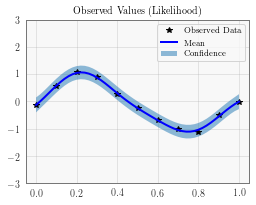

In [8]:
model.condition(train_x, train_y)
fig = plot_model_and_predictions(model)